# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 1.1.2+21.g0d80ed3.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

104 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 4.74 s, sys: 93.4 ms, total: 4.83 s
Wall time: 1min 50s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    
len(X.data)

CPU times: user 3.93 ms, sys: 5.12 ms, total: 9.05 ms
Wall time: 8.38 ms


0

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 2.47 s, sys: 82.7 ms, total: 2.55 s
Wall time: 11.1 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml') # Write this input to file
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
%%time
!mpirun -n {N_CPUS} python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 10 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt
________________________________
Version: 1.1.2+21.g0d80ed3.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE

In [12]:
!tail xopt.log

2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Running Xopt step
2022-08-17T17:15:55-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

2022-08-17 17:15:56,967 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-fflz3ib9', purging
2022-08-17 17:15:56,967 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-5dfiwtpj', purging
2022-08-17 17:15:56,967 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-trn_qz29', purging
2022-08-17 17:15:56,967 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-9c0aipu3', purging
2022-08-17 17:15:56,967 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-2sbni4ga', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57174,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57273,Total threads: 2
Dashboard: http://127.0.0.1:57274/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:57184,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 4.37 s, sys: 531 ms, total: 4.9 s
Wall time: 12.5 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,xopt_error,xopt_exception,xopt_traceback,xopt_runtime,y1,y2,c1,c2,some_array
3,0.175438,0.562070,dummy_constant,0.175438,False,None,,0.044449,0.175438,0.562070,-0.666097,0.109194,"[1, 2, 3]"
7,1.965109,2.027888,dummy_constant,1.965109,False,None,,0.079926,1.965109,2.027888,6.877130,4.480986,"[1, 2, 3]"
10,0.103565,0.429376,dummy_constant,0.103565,False,None,,0.106240,0.103565,0.429376,-0.725016,0.162148,"[1, 2, 3]"
9,2.627145,2.219831,dummy_constant,2.627145,False,None,,0.109147,2.627145,2.219831,10.806803,7.482565,"[1, 2, 3]"
12,1.130540,0.190300,dummy_constant,1.130540,False,None,,0.027481,1.130540,0.190300,0.403339,0.493495,"[1, 2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.199381,1.029265,dummy_constant,NaN,False,None,,0.083853,0.199381,1.029265,0.198819,0.370493,"[1, 2, 3]"
994,0.181839,0.970768,dummy_constant,NaN,False,None,,0.133564,0.181839,0.970768,0.073860,0.322849,"[1, 2, 3]"
1002,0.784951,0.821772,dummy_constant,NaN,False,None,,0.053534,0.784951,0.821772,0.198103,0.184734,"[1, 2, 3]"
996,0.974144,0.229597,dummy_constant,NaN,False,None,,0.119597,0.974144,0.229597,0.086297,0.297930,"[1, 2, 3]"


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,xopt_error,xopt_exception,xopt_traceback,xopt_runtime,y1,y2,c1,c2,some_array,feasible_c1,feasible_c2,feasible
12,1.130540,0.190300,dummy_constant,1.130540,False,None,,0.027481,1.130540,0.190300,0.403339,0.493495,"[1, 2, 3]",True,True,True
17,0.674760,1.046177,dummy_constant,0.674760,False,None,,0.053458,0.674760,1.046177,0.646442,0.328850,"[1, 2, 3]",True,True,True
63,0.919297,0.702188,dummy_constant,0.919297,False,None,,0.006251,0.919297,0.702188,0.391197,0.216690,"[1, 2, 3]",True,True,True
85,1.042577,0.132302,dummy_constant,1.042577,False,None,,0.123653,1.042577,0.132302,0.147860,0.429592,"[1, 2, 3]",True,True,True
100,0.821287,0.934609,dummy_constant,0.821287,False,None,,0.007537,0.821287,0.934609,0.496625,0.292110,"[1, 2, 3]",True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.199381,1.029265,dummy_constant,NaN,False,None,,0.083853,0.199381,1.029265,0.198819,0.370493,"[1, 2, 3]",True,True,True
994,0.181839,0.970768,dummy_constant,NaN,False,None,,0.133564,0.181839,0.970768,0.073860,0.322849,"[1, 2, 3]",True,True,True
1002,0.784951,0.821772,dummy_constant,NaN,False,None,,0.053534,0.784951,0.821772,0.198103,0.184734,"[1, 2, 3]",True,True,True
996,0.974144,0.229597,dummy_constant,NaN,False,None,,0.119597,0.974144,0.229597,0.086297,0.297930,"[1, 2, 3]",True,True,True


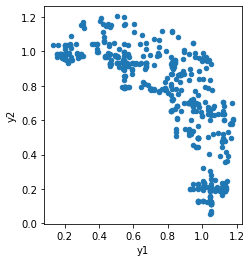

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

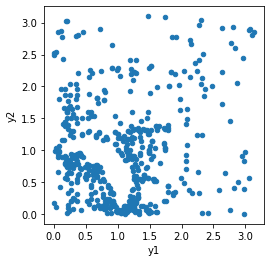

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

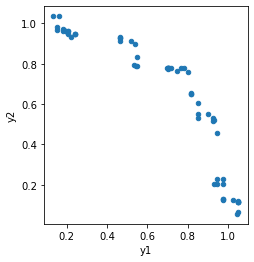

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

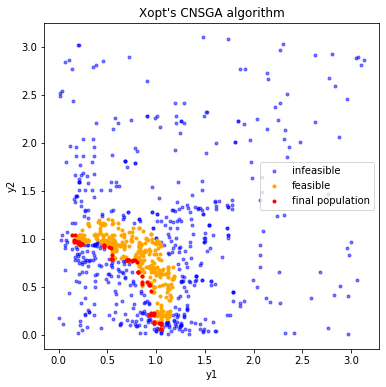

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml